## Homework 2: Deep Learning Foundation

### Obbjectives:
- Create sequential models
- Practice training deep learning models with PyTorch
- Learn how to use different techniques to fight with underfitting and overfitting
    - Model architecture: shallow vs. deep
    - Regularizers

Note, check `Lab 2: Overfitting_Underfitting` before you start working on this assignment. The lab should give you a good starting point.

### Description:  Classifying newswires: a multi-class classification

- In this assignment, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. 
- Since we have many classes and each data point should be classified into only one category, the problem is specifically an instance of <b>"single-label, multi-class classification"</b>. 

### The Reuters dataset

- _Reuters dataset_, is a set of short newswires and their topics, published by Reuters in 1986.  
- There are 46 different topics some topics are more represented than others, but each topic has at least 10 examples in the training set.
- The dataset can be loaded using the following script. Specifically, it retrieves 8,982 training examples and 2,246 test examples. The argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the data.

Note, here we only use Keras to download the dataset. Your deep learning model should be done by PyTorch.

In [ ]:
! pip install torchinfo

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow.keras
from tensorflow.keras.datasets import reuters
import pandas as pd

from torchinfo import summary

import matplotlib.pyplot as plt
from IPython import display

# add your import statement

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pprint import pprint

In [ ]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
# show the sizes training/testing samples 
print(len(train_data))
print(len(test_data))

2121728/2110848 [==============================] - 0s 0us/step
8982
2246


Each example is a list of integers, each corresponds to one word (word indices).  The following shows one example. Also, you can decode it back to words, in case you are curious:

In [ ]:
# show an example from the training dataset
print(train_data[10])

# retrieve the mapping from words to indices
word_index = reuters.get_word_index()

# reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index[i - 3] for i in train_data[0] if (i-3) in reverse_word_index])

decoded_newswire

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
565248/550378 [==============================] - 0s 0us/step


'said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index. In total, there are `46` topics.


The code below shows the label for one sample and also the distribution of labels. This dataset is very imbalanced. Some labels only have a few training samples.

In [ ]:
train_labels[10]

# distribution of labels

pd.Series(train_labels).value_counts().sort_values(ascending = False)

3

3     3159
4     1949
19     549
16     444
1      432
11     390
20     269
13     172
8      139
10     124
9      101
21     100
25      92
2       74
18      66
24      62
0       55
34      50
36      49
12      49
6       48
28      48
30      45
23      41
31      39
17      39
40      36
32      32
41      30
14      26
39      24
26      24
43      21
15      20
29      19
37      19
38      19
45      18
5       17
7       16
27      15
22      15
42      13
44      12
33      11
35      10
dtype: int64

### Prepare data
First, we'll follow the "bad-of-words" approach to generating sample representations. You can vectorize the data with the following code. Specifically,
- The training/test datasets is represented as a matrix
- Each sample is treated as a row, and each word is a column. 
- If a word (say $j$) appears in a sample (say $i$), 1 is recorded in the cell ($i, j$), and 0 otherwise.

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

# Get Y ready
y_train = np.array(train_labels)
y_test = np.array(test_labels)

x_train.shape
x_test.shape

y_train.shape
y_test.shape

(8982, 10000)

(2246, 10000)

(8982,)

(2246,)

### Q1: Create seqential models in different architectures


- Create three different sequential models as defined below. Use `ReLu` activation function for all hidden layers.
    - Model A: This model only has one hidden layer with 128 units. 
    - Model B: Similar to A, but this model adds a 2nd hidden layer with 64 units.
    - Model C: This model is similar to Model B except that the 2nd hidden layer has 16 units.
    

- Define a function `fit_model(model, train_dataset, test_dataset, *other parameters if appropriate* )`, and use this function to train each model. You'll need to tune hyperparameters. To help you get started, suggested values for some parameters are provided:
    - optimizer: RMSProp optimizer or Adam
    - loss: `pick a right loss function` from this list: https://pytorch.org/docs/stable/nn.html#loss-functions             
    - batch_size: 256
    - epoch: 30
    - learning rate: 0.0002


- After each training epoch, calculate the loss and accuracy of each model on the test dataset (i.e. `x_test, y_test`)


- Return training history. Plot test loss and accuracy vs. epoches from the training histories of these three models
    - Reference plots are provided for your reference. You may generate different plots.
    - In general, the best test accuracy of this problem should not be lower than `75%`.


- Write your analysis (as markdowns) on the following: 
   - For each model, from which epoch, overfitting started happening?
   - Which model in general performs better than the others in terms of test loss or test accuracy? 
   - Please explain why this model outperforms the others

In [ ]:
# fix random number

random_seed = 7777
# seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# Create dataset class

class news_dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.from_numpy(x).float()
        self.y = y
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.x.size()[0]

train_data = news_dataset(x_train, y_train)
test_data = news_dataset(x_test, y_test)


In [ ]:
# Define your models: A, B, C

class linear_model(nn.Module):
    def __init__(self, hidden_l1, hidden_l2):  # add more parameters if needsed
        
       # add your code
        super(linear_model, self).__init__()
        if hidden_l2 != 0:
            self.classifier = nn.Sequential(
                nn.Linear(in_features=10000, out_features=hidden_l1),
                nn.ReLU(),
                nn.Linear(in_features=hidden_l1, out_features=hidden_l2),
                nn.ReLU(),
                nn.Linear(in_features=hidden_l2, out_features=46)
           )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(in_features=10000, out_features=hidden_l1),
                nn.ReLU(),
                nn.Linear(in_features=hidden_l1, out_features=46)
            )
    
    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
# Define a train function


def train_model(model,
                train_dataset, 
                test_dataset, 
                device,
                epochs=50,
                lr=0.0002, 
                batch_size=256, 
                regularizer=0,
                
                ):  # add more parameters if needed
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=regularizer)
    criterion=nn.CrossEntropyLoss()

    model = model.to(device)

    train_history = {'train_loss': [],
                    'train_acc': [],
                    'test_loss': [],
                    'test_acc': []}

    
    

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            score, pred = torch.max(outputs, 1) 
            cur_train_loss = criterion(outputs, y)
         
            cur_train_acc = (pred == y).sum().float() / batch_size

            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad() 

            train_loss += cur_train_loss
            train_acc += cur_train_acc

        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                score, pred = torch.max(outputs, 1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().float() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)

        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)
        train_history['test_loss'].append(val_loss)
        train_history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.5f} train_acc:{train_acc:.5f}, valid loss:{val_loss:.5f} valid acc:{val_acc:.5f}")
        # display.clear_output(wait=True)
 
    return train_history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Train Model A

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

regularizer=0
modela = linear_model(hidden_l1=128,hidden_l2=0)
summary(modela, (24, 10000))
hista = train_model(modela, train_dataset, test_dataset, device)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 46]                  5,934
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.03
Params size (MB): 5.14
Estimated Total Size (MB): 6.14

Epoch:1 / 50, train loss:2.58390 train_acc:0.53939, valid loss:1.98712 valid acc:0.62370
Epoch:2 / 50, train loss:1.65453 train_acc:0.66591, valid loss:1.59444 valid acc:0.65929
Epoch:3 / 50, train loss:1.33569 train_acc:0.70964, valid loss:1.40550 valid acc:0.68403
Epoch:4 / 50, train loss:1.14915 train_acc:0.74262, valid loss:1.29075 valid acc:0.69922
Epoch:5 / 50, train loss:1.01983 train_acc:0.76671, valid loss:1.21010 valid acc:0.71658
Epoch:6 / 50, train loss:0.91968 train_acc:0.78776, valid loss:1.14922 valid acc:0.73134
Epoch:7 / 50, train loss:0.83721 train_acc:0.80534, valid loss:1.10032 valid acc:0.74306
Epoch:8 / 50, train loss:0.76634 train_acc:0.82096, valid loss:1.05970 valid acc:0.74957
Epoch:9 / 50, train loss:0.70392 train_acc:0.83333, valid loss:1.02508 valid acc:0.75738
Epoch:10 / 50, train loss:0.64806 train_acc:0.84863, valid loss:0.99526 valid acc:0.76345
Epoch:11 / 50, train loss:0.59757 train_acc:0.85720, valid loss:0.96942 valid acc:0.76866
Epoch:12 / 50, trai

In [ ]:
# Train Model B

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modelb = linear_model(hidden_l1=128, hidden_l2=64)

summary(modelb, (24, 10000))

histb = train_model(modelb, train_dataset, test_dataset, device, epochs=50)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 64]                  8,256
│    └─ReLU: 2-4                         [24, 64]                  --
│    └─Linear: 2-5                       [24, 46]                  2,990
Total params: 1,291,374
Trainable params: 1,291,374
Non-trainable params: 0
Total mult-adds (M): 30.99
Input size (MB): 0.96
Forward/backward pass size (MB): 0.05
Params size (MB): 5.17
Estimated Total Size (MB): 6.17

Epoch:1 / 50, train loss:2.52736 train_acc:0.45475, valid loss:1.86487 valid acc:0.58030
Epoch:2 / 50, train loss:1.61581 train_acc:0.63509, valid loss:1.57498 valid acc:0.64497
Epoch:3 / 50, train loss:1.37625 train_acc:0.67925, valid loss:1.44603 valid acc:0.66753
Epoch:4 / 50, train loss:1.23003 train_acc:0.70356, valid loss:1.36170 valid acc:0.67839
Epoch:5 / 50, train loss:1.11798 train_acc:0.72960, valid loss:1.29679 valid acc:0.68880
Epoch:6 / 50, train loss:1.02529 train_acc:0.75022, valid loss:1.24481 valid acc:0.69618
Epoch:7 / 50, train loss:0.94460 train_acc:0.76986, valid loss:1.19986 valid acc:0.70877
Epoch:8 / 50, train loss:0.87232 train_acc:0.78537, valid loss:1.16178 valid acc:0.72092
Epoch:9 / 50, train loss:0.80654 train_acc:0.79839, valid loss:1.12804 valid acc:0.73047
Epoch:10 / 50, train loss:0.74455 train_acc:0.81066, valid loss:1.09828 valid acc:0.73915
Epoch:11 / 50, train loss:0.68703 train_acc:0.82205, valid loss:1.07280 valid acc:0.74349
Epoch:12 / 50, trai

In [ ]:
# Train Model C

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)
modelc = linear_model(128, 16)
summary(modelc, (24, 10000))
histc = train_model(modelc, train_dataset, test_dataset, device, epochs=50)

Layer (type:depth-idx)                   Output Shape              Param #
linear_model                             --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Linear: 2-1                       [24, 128]                 1,280,128
│    └─ReLU: 2-2                         [24, 128]                 --
│    └─Linear: 2-3                       [24, 16]                  2,064
│    └─ReLU: 2-4                         [24, 16]                  --
│    └─Linear: 2-5                       [24, 46]                  782
Total params: 1,282,974
Trainable params: 1,282,974
Non-trainable params: 0
Total mult-adds (M): 30.79
Input size (MB): 0.96
Forward/backward pass size (MB): 0.04
Params size (MB): 5.13
Estimated Total Size (MB): 6.13

Epoch:1 / 50, train loss:3.19798 train_acc:0.41526, valid loss:2.49390 valid acc:0.56814
Epoch:2 / 50, train loss:2.08480 train_acc:0.60004, valid loss:1.92727 valid acc:0.61241
Epoch:3 / 50, train loss:1.69296 train_acc:0.64236, valid loss:1.71378 valid acc:0.63411
Epoch:4 / 50, train loss:1.49742 train_acc:0.66851, valid loss:1.59192 valid acc:0.65104
Epoch:5 / 50, train loss:1.36514 train_acc:0.68826, valid loss:1.50813 valid acc:0.66233
Epoch:6 / 50, train loss:1.26227 train_acc:0.70226, valid loss:1.44175 valid acc:0.67014
Epoch:7 / 50, train loss:1.17568 train_acc:0.71669, valid loss:1.38755 valid acc:0.67752
Epoch:8 / 50, train loss:1.10002 train_acc:0.72938, valid loss:1.34045 valid acc:0.68099
Epoch:9 / 50, train loss:1.03263 train_acc:0.74273, valid loss:1.29999 valid acc:0.68880
Epoch:10 / 50, train loss:0.97171 train_acc:0.75629, valid loss:1.26350 valid acc:0.69661
Epoch:11 / 50, train loss:0.91575 train_acc:0.76747, valid loss:1.23139 valid acc:0.70226
Epoch:12 / 50, trai

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

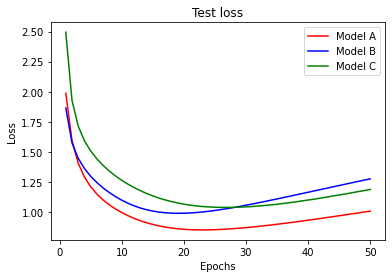

In [ ]:
# Plot test loss curves
epochs = range(1, len(hista['train_loss']) + 1)

plt.plot(epochs, hista['test_loss'], 'r-', label='Model A')
plt.plot(epochs, histb['test_loss'], 'b-', label='Model B')
plt.plot(epochs, histc['test_loss'], 'g-', label='Model C')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

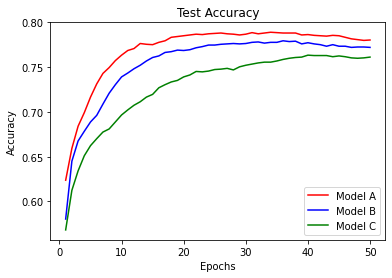

In [ ]:
# Plot test accuracy curves

epochs = range(1, len(hista['test_acc']) + 1)

plt.plot(epochs, hista['test_acc'], 'r-', label='Model A');
plt.plot(epochs, histb['test_acc'], 'b-', label='Model B');
plt.plot(epochs, histc['test_acc'], 'g-', label='Model C');

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

### Q2: Fight overfitting 
- Take the `best model` you achieved from Q1 and add regularizers in order to reduce or at least delay overfitting without hurting its classification accuracy. You can consider the following strategies:
    1. `dropout`: Add Dropout layers to input or hidden layers
    2. `Batch Normalization`: Add Batch Normalization layers after hidden layers.
    3. `L1/L2 Regularizer`: Add L2/L1 normal penality with appropriate coefficient.


- Pick one or a combination of strategies and modify the model


- Train the  model as in Q1 


- Plot test loss and test accuracy vs. epoches from the training histories of all the models.


- Write your analysis (as markdowns) on the following: 
   - Are you able to find a good strategy to address overfitting in this case? If so, why do you think the strategy you used can be effective?
   - What other strategies have you tried? Are they effective?
   - Overall, through Q1 and Q2, can you summarize what you have learned regarding modeling and training?
   - Note, this is an open question. Feel free to share you learning experience. We'll summarize all students' analyses and share them in class.
  

A reference plot is provided. However, depending on the strategy you choose, you may get a different plot.

## DropOut

Layer (type:depth-idx)                   Output Shape              Param #
linear_model_with_regularizer            --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Dropout: 2-1                      [24, 10000]               --
│    └─Linear: 2-2                       [24, 128]                 1,280,128
│    └─ReLU: 2-3                         [24, 128]                 --
│    └─Dropout: 2-4                      [24, 128]                 --
│    └─Linear: 2-5                       [24, 46]                  5,934
Total params: 1,286,062
Trainable params: 1,286,062
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.03
Params size (MB): 5.14
Estimated Total Size (MB): 6.14

Epoch:1 / 50, train loss:2.73863 train_acc:0.49132, valid loss:2.12674 valid acc:0.56120
Epoch:2 / 50, train loss:1.95077 train_acc:0.58898, valid loss:1.76436 valid acc:0.61936
Epoch:3 / 50, train loss:1.68655 train_acc:0.62739, valid loss:1.59036 valid acc:0.64670
Epoch:4 / 50, train loss:1.54574 train_acc:0.64768, valid loss:1.48289 valid acc:0.66319
Epoch:5 / 50, train loss:1.44708 train_acc:0.66732, valid loss:1.40780 valid acc:0.67144
Epoch:6 / 50, train loss:1.36231 train_acc:0.68077, valid loss:1.34865 valid acc:0.68490
Epoch:7 / 50, train loss:1.29425 train_acc:0.69716, valid loss:1.30218 valid acc:0.68924
Epoch:8 / 50, train loss:1.24796 train_acc:0.70302, valid loss:1.26380 valid acc:0.69792
Epoch:9 / 50, train loss:1.20134 train_acc:0.71484, valid loss:1.23061 valid acc:0.70486
Epoch:10 / 50, train loss:1.14600 train_acc:0.72645, valid loss:1.19983 valid acc:0.71267
Epoch:11 / 50, train loss:1.11222 train_acc:0.72971, valid loss:1.17251 valid acc:0.72439
Epoch:12 / 50, trai

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

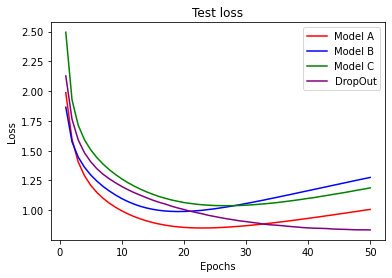

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

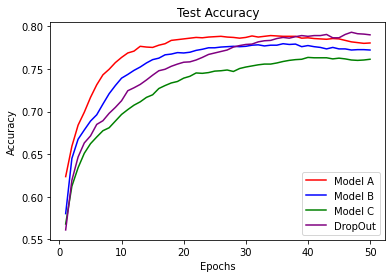

In [ ]:
# Define model with  - DropOut 
class linear_model_with_regularizer(nn.Module):
    def __init__(self, hidden_l1,dropout_ratio=0):  # add more parameters if needsed
        
       # add your code
        super(linear_model_with_regularizer, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=10000, out_features=hidden_l1),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=hidden_l1, out_features=46)
        )
    
    def forward(self, x):
        output = self.classifier(x)
        return output

# Train model with regularizer - DropOut

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modeld = linear_model_with_regularizer(hidden_l1=128, dropout_ratio=0.5)
summary(modeld, (24, 10000))

histd = train_model(modeld, train_dataset, test_dataset, device, epochs=50)

# Plot validation loss curves
epochs = range(1, len(hista['train_loss']) + 1)

plt.plot(epochs, hista['test_loss'], 'r-', label='Model A')
plt.plot(epochs, histb['test_loss'], 'b-', label='Model B')
plt.plot(epochs, histc['test_loss'], 'g-', label='Model C')
plt.plot(epochs, histd['test_loss'], '-', color='purple', label='DropOut')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot validation accuracy curves
epochs = range(1, len(hista['test_acc']) + 1)

plt.plot(epochs, hista['test_acc'], 'r-', label='Model A');
plt.plot(epochs, histb['test_acc'], 'b-', label='Model B');
plt.plot(epochs, histc['test_acc'], 'g-', label='Model C');
plt.plot(epochs, histd['test_acc'], '-', color='purple', label='DropOut');

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

## BatchNorm

Layer (type:depth-idx)                   Output Shape              Param #
linear_model_with_regularizer            --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Dropout: 2-1                      [24, 10000]               --
│    └─Linear: 2-2                       [24, 128]                 1,280,128
│    └─ReLU: 2-3                         [24, 128]                 --
│    └─BatchNorm1d: 2-4                  [24, 128]                 256
│    └─Dropout: 2-5                      [24, 128]                 --
│    └─Linear: 2-6                       [24, 46]                  5,934
Total params: 1,286,318
Trainable params: 1,286,318
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.06
Params size (MB): 5.15
Estimated Total Size (MB): 6.16

Epoch:1 / 50, train loss:1.49385 train_acc:0.72613, valid loss:2.27028 valid acc:0.77734
Epoch:2 / 50, train loss:0.58087 train_acc:0.89117, valid loss:1.07605 valid acc:0.79297
Epoch:3 / 50, train loss:0.36874 train_acc:0.91688, valid loss:0.99433 valid acc:0.79036
Epoch:4 / 50, train loss:0.27049 train_acc:0.92122, valid loss:0.98775 valid acc:0.78689
Epoch:5 / 50, train loss:0.21759 train_acc:0.92198, valid loss:0.98321 valid acc:0.78776
Epoch:6 / 50, train loss:0.18656 train_acc:0.92112, valid loss:0.98869 valid acc:0.78819
Epoch:7 / 50, train loss:0.16514 train_acc:0.92079, valid loss:0.99335 valid acc:0.78733
Epoch:8 / 50, train loss:0.14925 train_acc:0.91992, valid loss:1.00293 valid acc:0.78863
Epoch:9 / 50, train loss:0.13532 train_acc:0.91970, valid loss:1.00797 valid acc:0.78646
Epoch:10 / 50, train loss:0.12278 train_acc:0.92036, valid loss:1.02091 valid acc:0.78646
Epoch:11 / 50, train loss:0.11088 train_acc:0.92133, valid loss:1.02647 valid acc:0.78733
Epoch:12 / 50, trai

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

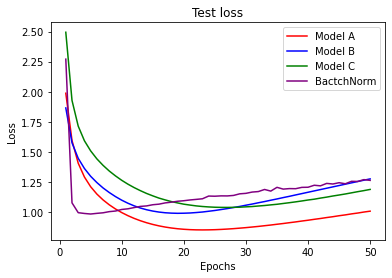

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

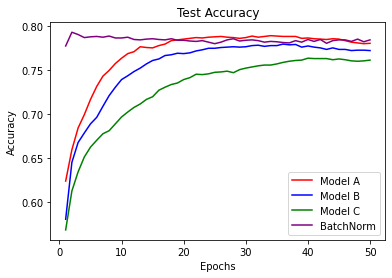

In [ ]:
# Define model with  - BatchNorm 
class linear_model_with_regularizer(nn.Module):
    def __init__(self, hidden_l1,dropout_ratio=0):  # add more parameters if needsed
        
       # add your code
        super(linear_model_with_regularizer, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=10000, out_features=hidden_l1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_l1),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=hidden_l1, out_features=46)
        )
    
    def forward(self, x):
        output = self.classifier(x)
        return output
    

# Train model with regularizer - BactchNorm

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modele = linear_model_with_regularizer(hidden_l1=128)
summary(modele, (24, 10000))

histe = train_model(modele, train_dataset, test_dataset, device, epochs=50)

# Plot validation loss curves
epochs = range(1, len(hista['train_loss']) + 1)

plt.plot(epochs, hista['test_loss'], 'r-', label='Model A')
plt.plot(epochs, histb['test_loss'], 'b-', label='Model B')
plt.plot(epochs, histc['test_loss'], 'g-', label='Model C')
plt.plot(epochs, histe['test_loss'], '-', color='purple', label='BactchNorm')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot validation accuracy curves
epochs = range(1, len(hista['test_acc']) + 1)

plt.plot(epochs, hista['test_acc'], 'r-', label='Model A');
plt.plot(epochs, histb['test_acc'], 'b-', label='Model B');
plt.plot(epochs, histc['test_acc'], 'g-', label='Model C');
plt.plot(epochs, histe['test_acc'], '-', color='purple', label='BatchNorm');

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

## L2 Reqularization

Layer (type:depth-idx)                   Output Shape              Param #
linear_model_with_regularizer            --                        --
├─Sequential: 1-1                        [24, 46]                  --
│    └─Dropout: 2-1                      [24, 10000]               --
│    └─Linear: 2-2                       [24, 128]                 1,280,128
│    └─ReLU: 2-3                         [24, 128]                 --
│    └─BatchNorm1d: 2-4                  [24, 128]                 256
│    └─Dropout: 2-5                      [24, 128]                 --
│    └─Linear: 2-6                       [24, 46]                  5,934
Total params: 1,286,318
Trainable params: 1,286,318
Non-trainable params: 0
Total mult-adds (M): 30.87
Input size (MB): 0.96
Forward/backward pass size (MB): 0.06
Params size (MB): 5.15
Estimated Total Size (MB): 6.16

Epoch:1 / 50, train loss:2.46548 train_acc:0.55729, valid loss:1.88987 valid acc:0.63325
Epoch:2 / 50, train loss:1.57790 train_acc:0.67480, valid loss:1.54667 valid acc:0.66623
Epoch:3 / 50, train loss:1.29129 train_acc:0.71745, valid loss:1.38316 valid acc:0.68620
Epoch:4 / 50, train loss:1.12386 train_acc:0.75076, valid loss:1.28127 valid acc:0.70269
Epoch:5 / 50, train loss:1.00562 train_acc:0.77105, valid loss:1.20867 valid acc:0.71962
Epoch:6 / 50, train loss:0.91269 train_acc:0.78961, valid loss:1.15254 valid acc:0.73220
Epoch:7 / 50, train loss:0.83495 train_acc:0.80599, valid loss:1.10680 valid acc:0.73958
Epoch:8 / 50, train loss:0.76737 train_acc:0.81966, valid loss:1.06818 valid acc:0.74479
Epoch:9 / 50, train loss:0.70732 train_acc:0.83192, valid loss:1.03491 valid acc:0.75521
Epoch:10 / 50, train loss:0.65321 train_acc:0.84201, valid loss:1.00596 valid acc:0.75955
Epoch:11 / 50, train loss:0.60408 train_acc:0.85265, valid loss:0.98059 valid acc:0.76389
Epoch:12 / 50, trai

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

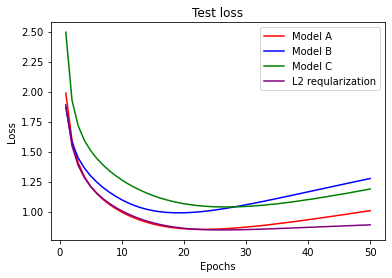

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

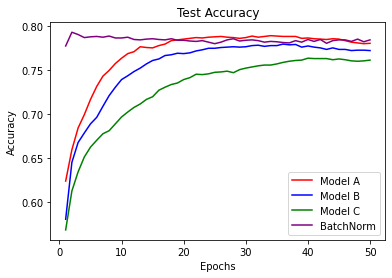

In [ ]:
# Define model with  - L2 reqularization 
class linear_model_with_regularizer(nn.Module):
    def __init__(self, hidden_l1,dropout_ratio=0):  # add more parameters if needsed
        
       # add your code
        super(linear_model_with_regularizer, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=10000, out_features=hidden_l1),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=hidden_l1, out_features=46)
        )
    
    def forward(self, x):
        output = self.classifier(x)
        return output
    

# Train model with regularizer - L2 reqularization

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modelh = linear_model_with_regularizer(hidden_l1=128)
summary(modele, (24, 10000))

histh = train_model(modelh, train_dataset, test_dataset, device, epochs=50, regularizer=0.0001)

# Plot validation loss curves
epochs = range(1, len(hista['train_loss']) + 1)

plt.plot(epochs, hista['test_loss'], 'r-', label='Model A')
plt.plot(epochs, histb['test_loss'], 'b-', label='Model B')
plt.plot(epochs, histc['test_loss'], 'g-', label='Model C')
plt.plot(epochs, histh['test_loss'], '-', color='purple', label='L2 reqularization')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot validation accuracy curves
epochs = range(1, len(hista['test_acc']) + 1)

plt.plot(epochs, hista['test_acc'], 'r-', label='Model A');
plt.plot(epochs, histb['test_acc'], 'b-', label='Model B');
plt.plot(epochs, histc['test_acc'], 'g-', label='Model C');
plt.plot(epochs, histe['test_acc'], '-', color='purple', label='BatchNorm');

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

## DropOut + BatchNorm

Epoch:1 / 50, train loss:2.80540 train_acc:0.49327, valid loss:2.21742 valid acc:0.56727
Epoch:2 / 50, train loss:2.02275 train_acc:0.58116, valid loss:1.82214 valid acc:0.62153
Epoch:3 / 50, train loss:1.73122 train_acc:0.62272, valid loss:1.62661 valid acc:0.64236
Epoch:4 / 50, train loss:1.56807 train_acc:0.64800, valid loss:1.50720 valid acc:0.65799
Epoch:5 / 50, train loss:1.46250 train_acc:0.66721, valid loss:1.42505 valid acc:0.67057
Epoch:6 / 50, train loss:1.37643 train_acc:0.68359, valid loss:1.36443 valid acc:0.68099
Epoch:7 / 50, train loss:1.30797 train_acc:0.69347, valid loss:1.31417 valid acc:0.68924
Epoch:8 / 50, train loss:1.25448 train_acc:0.70486, valid loss:1.27357 valid acc:0.69835
Epoch:9 / 50, train loss:1.20621 train_acc:0.71278, valid loss:1.23856 valid acc:0.70790
Epoch:10 / 50, train loss:1.15778 train_acc:0.72179, valid loss:1.20819 valid acc:0.71311
Epoch:11 / 50, train loss:1.11664 train_acc:0.73535, valid loss:1.18123 valid acc:0.72222
Epoch:12 / 50, trai

Text(0.5, 1.0, 'Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

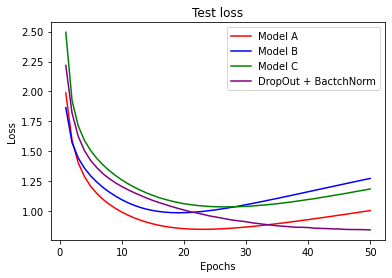

Text(0.5, 1.0, 'Test Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

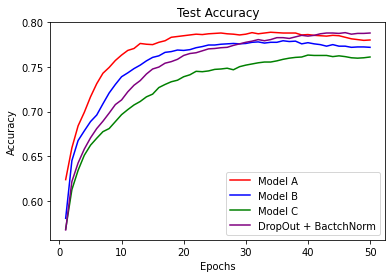

In [ ]:
# Train model with regularizer - DropOut + BactchNorm

# dataset
train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)

modelf = linear_model_with_regularizer(128, dropout_ratio=0.5)

histf = train_model(modelf, train_dataset, test_dataset, device, epochs=50)

# Plot validation loss curves
epochs = range(1, len(hista['train_loss']) + 1)

plt.plot(epochs, hista['test_loss'], 'r-', label='Model A')
plt.plot(epochs, histb['test_loss'], 'b-', label='Model B')
plt.plot(epochs, histc['test_loss'], 'g-', label='Model C')
plt.plot(epochs, histf['test_loss'], '-', color='purple', label='DropOut + BactchNorm')

plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot validation accuracy curves
epochs = range(1, len(hista['test_acc']) + 1)

plt.plot(epochs, hista['test_acc'], 'r-', label='Model A');
plt.plot(epochs, histb['test_acc'], 'b-', label='Model B');
plt.plot(epochs, histc['test_acc'], 'g-', label='Model C');
plt.plot(epochs, histf['test_acc'], '-', color='purple', label='DropOut + BactchNorm');

plt.title('Test Accuracy');
plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.legend();

plt.show()

# Analysis 

- **Are you able to find a good strategy to address overfitting in this case? If so, why do you think the strategy you used can be effective?**
    - After trying dropout, batch normalization and combination of batch normalization and dropout out I found dropout technique(dropout ratio=0.5) is a best way to fight the overfitting problem resulting in better train and validation accuracy compared to the rest of the technique

    - Reasons: With dropout technique we are dropping some of the results of the units which makes our network less complex. Hence dropout enables the model to learn the parameters quickly compared to other technique. 

- **What other strategies have you tried? Are they effective?**
    - I tried the following techniques: 

    1. _L1 and L2 regularization_: over fitting occurs when the model is complex. One must proceed with a simpler model and one of the ways to make the model less complex is to put constrains on the complexity of the model. This can be achieved by forcing the weights to take smaller values. L1/L2 regulizers controls the weights of the model. Here the loss function of the network is given a penality for having large weights.
    2. _Batch normalization_: With batch normalization we are normalizing the weights of a layer wich takes mean and variance into consideration, hence reducing the effect of outliers. As a secondary effect it also helps us in dealing with imbalenced dataset which is true in our case. With Batch Normalization we converge quickly, and and get the optmium as early as in 10 epochs and later on we start overfitting, as can be seen in the plots above.
    3. _Batch normalization with dropout_: This techniques is effective as it combines the effect of dropout and normalization. It reduces complexity of the model. But in our case the individual works better than the combination.

In conclusion we can see that combination of batch normalization and drop out seems to be perfomrming well

- **Overall, through Q1 and Q2, can you summarize what you have learned regarding modeling and training?**
    1. Begin with simpler models as with complex model we can run into the probelm of overfitting.
    2. I have found that having less number of hidden layers but with more number of hidden nodes is a better beginning point. Neural networks unwraps the data in higer dimension which helps to move the data easier. 

    4. Optimization techiniques like dropout, weight decay, batch normalizations are good way to fight over fightting. There high chances to commit error with a slight change in the values for dropout ratio, weight decay. It is a good statergy to have a well calculated values before making any changes. And a visual graph is of great help.

### Q3 (Bonus): Imbalanced Dataset

Here we have a very imbalance dataset. Many classes only have a few training samples. As a result, when you display the classification report (see below), you'll see precision/recall/f1 is very low for some classes. 

Assuming that it is very difficult to collect extra samples, could you think of one method to improve the peformance of some underpresented classes without hurting the overall performance?

Implement your method and demonstrate the improvement you can achieve. 

Please describe your method as markdowns and explain why this method can address dataset skewness.

## How to deal with imbalanced dataset:
In this case we can see that class 3 and 4 are heavily represented. 
We can use one of the two following techniques. 
1. Under sampling 
2. Over sampling

**Under Sampling** 
- I first tried deleting the rows that where over represented form the data set. I decided that I should cap the samples of each class at 300. But with that, test data goes down to 3949 which in comparison with 8000 we are loosing a lot of information. So decided that is not a sound strategy.

**Oversampling**
- In this technique the idea is to over sample the minority class. I did it by copying over minority classes to come to a minimum of 300 samples per class. With this approach I could not run it on colab, it always kept running out of memory.
- Further more I looked into using sklearn imbalanced contrib library. 

**I have implemented the sampling using sklearn imbalanced-learn library in a different colab notebook since it was difficult to run because of the memory limitation. I have attached the collab with the current file**

- My observation from there were, I was not able to come to a very good learning rate, weight decay and reqularization parameters with provided better accuracy than what we have in the best model described above. 
- I was running into over fitting probelm which I could not fiqure out how to work through. 

In [ ]:
class linear_model_with_regularizer2(nn.Module):
    def __init__(self, hidden_l1,dropout_ratio=0):  # add more parameters if needsed
        
       # add your code
        super(linear_model_with_regularizer2, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=10000, out_features=hidden_l1),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_l1),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(in_features=hidden_l1, out_features=46)
        )
    
    def forward(self, x):
        output = self.classifier(x)
        return output

In [ ]:
# train_dataset = news_dataset(x_train, y_train)
test_dataset = news_dataset(x_test, y_test)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelg = linear_model_with_regularizer2(hidden_l1=128, dropout_ratio=0.65)
lr=0.001
regularizer=0.0003
optimizer = torch.optim.Adam(modelg.parameters(), lr=lr, weight_decay=regularizer)
# summary(modeld, (24, 10000))

histg = train_model(modelg, train_dataset, test_dataset, device, epochs=50)

Epoch:1 / 50, train loss:2.65818 train_acc:0.44878, valid loss:2.48126 valid acc:0.68359
Epoch:2 / 50, train loss:1.92821 train_acc:0.61469, valid loss:1.58176 valid acc:0.70226
Epoch:3 / 50, train loss:1.67661 train_acc:0.66059, valid loss:1.42883 valid acc:0.71875
Epoch:4 / 50, train loss:1.50576 train_acc:0.68945, valid loss:1.32324 valid acc:0.73394
Epoch:5 / 50, train loss:1.38996 train_acc:0.70540, valid loss:1.25575 valid acc:0.73872
Epoch:6 / 50, train loss:1.30477 train_acc:0.72233, valid loss:1.20851 valid acc:0.74566
Epoch:7 / 50, train loss:1.21905 train_acc:0.73611, valid loss:1.15513 valid acc:0.75955
Epoch:8 / 50, train loss:1.13885 train_acc:0.74924, valid loss:1.11384 valid acc:0.76259
Epoch:9 / 50, train loss:1.07158 train_acc:0.76194, valid loss:1.08145 valid acc:0.76649
Epoch:10 / 50, train loss:1.03413 train_acc:0.76704, valid loss:1.05285 valid acc:0.76997
Epoch:11 / 50, train loss:0.99024 train_acc:0.77485, valid loss:1.02687 valid acc:0.77431
Epoch:12 / 50, trai

In [ ]:
test_loader = DataLoader(test_dataset)
model = modelg.to(device)
model.eval()
preds = []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        outputs = modelg(x)
        score,pred = torch.max(outputs, 1)
        preds.append(pred.cpu().detach().numpy()[0])

y_true = y_test
y_pred = np.array(preds)

linear_model_with_regularizer2(
  (classifier): Sequential(
    (0): Dropout(p=0.65, inplace=False)
    (1): Linear(in_features=10000, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.65, inplace=False)
    (5): Linear(in_features=128, out_features=46, bias=True)
  )
)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

              precision    recall  f1-score      support
0              0.875000  0.583333  0.700000    12.000000
1              0.598639  0.838095  0.698413   105.000000
2              0.764706  0.650000  0.702703    20.000000
3              0.931873  0.942189  0.937003   813.000000
4              0.846918  0.898734  0.872057   474.000000
5              0.000000  0.000000  0.000000     5.000000
6              0.812500  0.928571  0.866667    14.000000
7              1.000000  0.333333  0.500000     3.000000
8              0.722222  0.684211  0.702703    38.000000
9              0.833333  0.800000  0.816327    25.000000
10             0.958333  0.766667  0.851852    30.000000
11             0.612245  0.722892  0.662983    83.000000
12             0.500000  0.307692  0.380952    13.000000
13             0.538462  0.567568  0.552632    37.000000
14             0.000000  0.000000  0.000000     2.000000
15             0.500000  0.111111  0.181818     9.000000
16             0.660870  0.7676

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
